# Introduction
This notebook is contains 5 main sections, each section can be run on its own without running the sections before. Within each section, the cells have to be run in sequence. Before that, the cell after this has to be run first. This notebook is to be run on a cuda-enabled device.

*   Data Visualisation
*   Model - Training
*   Model - Testing
*   Display Results
*   Attacks
*   Interpretability





In [4]:
# MUST RUN THIS FIRST!!!

#---------- IMPORTS -----------#
# data analytics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# for image and dataset loading
from PIL import Image
from imageio import imread
from scipy import ndimage

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

# misc
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import re
from datetime import datetime
from zipfile import ZipFile

# custom code
from utils.datasets import *
from utils.config import *
from utils.network import *
from utils.netMixin import *
from utils.attacks import *

# init the torch seeds
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(100)
torch.cuda.manual_seed(100)
np.random.seed(100)

#---------- preparing the data ----------#
# file dirs
data_filename = 'data/nyu_data.zip'
train_csv_filename = 'data/nyu2_train.csv'
test_csv_filename = 'data/nyu2_test.csv'

# extract filenames from zip file
zf = ZipFile(data_filename)
train_data = zf.read(train_csv_filename).decode("utf-8") 
train_data = np.array([line.split(',') for line in train_data.split()])

# define train validation set split ratio
train_val_test_ratio = [0.7, 0.1, 0.2]

# get (train, val, test) start and end indices
_, train_end, val_end = [sum(train_val_test_ratio[:n]) for n in range(len(train_val_test_ratio))]
train_end = val_start = floor(train_end * len(train_data))
val_end = test_start = floor(val_end * len(train_data))

# train_data contains paths to xs and ys, spliting it for train, val and test
train_xy = train_data[:train_end]
val_xy = train_data[val_start:val_end]
test_xy = train_data[test_start:]

# Data visualisation

In [ ]:
#-------- init datasets ----------#
datasets = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}

@interact(name=['train', 'val', 'test'], index=(0, 500))
def see(name, index):
    ds = datasets[name]
    print('{} dataset has {} image-depthmap pairs.'.format(name, len(ds)))
    ds.show_images(index)

interactive(children=(Dropdown(description='name', options=('train', 'val', 'test'), value='train'), IntSlider…

# Model - Training

In [ ]:
#-------- init model for training --------#
hidden_layers = 8
model = depth8sig(hidden_layers)

#--------- init dataloaders for training ----------#
datasets = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}
trainloader, validloader, _ = get_dataloaders(datasets, {'batch_size': 16})

#--------- set hyperparams --------------#
weight_decay = 1e-5
lr = 0.001
eps = 2
criterion = depthEstLossLog()
optimizer = torch.optim.RMSprop(model.parameters(), weight_decay=weight_decay, lr=lr)

#-------- training loop ----------#
# Note:
# This training loop is just a sample to train your own model.
# Our model, models/Depth8.pt is trained with this function with 15 eps.

losses = model.train_model(
    trainloader,
    validloader,
    eps,
    optimizer,
    criterion,
    save_location='models/new_model.pt'
)

---------- Epoch 1 of 2 @ 03-05-2021 09:04:23 ----------



Average training loss: 0.3272072247223663



Average Validation Loss: 0.283

---------- Epoch 2 of 2 @ 03-05-2021 09:54:01 ----------



Average training loss: 0.20607440845293234



Average Validation Loss: 0.242



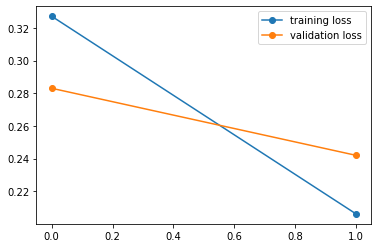

In [ ]:
#-------- plot losses -----------#
eps = [x[0] for x in losses]
training_losses = [x[1] for x in losses]
validation_losses = [x[2] for x in losses]

plt.plot(eps, training_losses, '-o', label="training loss")
plt.plot(eps, validation_losses, '-o', label='validation loss')
plt.legend()
plt.show()

# Model - Testing

In [ ]:
#--------- get trained model ----------#
trained_model = depth8sig(8)
trained_model.load_model('models/Depth8.pt') # change this to new model to find out how the new model does
criterion = depthEstLossLog()

#--------- init dataloaders for testing ----------#
datasets = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}
_, _, testloader = get_dataloaders(datasets, {'batch_size': 16})

# Test the model and get results
advanced = True # get advanced metrics instead of just test loss
scores = trained_model.test_model(testloader, criterion, advanced=advanced)
metrics = ['Average Test loss', 'Average d1 Score', 'Average d2 Score', 'Average d3 Score', 'Average RMS Error', 'Absolute Relative Error', 'Average Squared Relative Difference', 'Average Mean log10 Error']
pd.DataFrame(data={'Metrics': metrics, 'Scores':scores})

# Display Results

In [5]:
#--------- get trained model ----------#
trained_model = depth8sig(8)
trained_model.load_model('models/Depth8_cpu.pt') # change this to new model to find out how the new model does
criterion = depthEstLossLog()

In [6]:
testset = depth_est_dataset_v2(test_xy, zf)
@interact(index=(0, len(testset)-1))
def see(index):
    index=int(index)
    x, y = testset[index]
    display_predictions(trained_model, x, y, criterion)

interactive(children=(IntSlider(value=5068, description='index', max=10137), Output()), _dom_classes=('widget-…

# Attacks

In [8]:
#--------- get trained model ----------#
trained_model = depth8sig(8)
trained_model.load_model('models/Depth8.pt') # change this to new model to find out how the new model does
criterion = depthEstLossLog()

#------ init original dataset for comparison------#
datasets = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}
testset = datasets['test']

#--------- init fresh datasets to perform attack transformations ----------#
datasets_att = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}
testset_att = datasets_att['test']
_, _, testloader_att = get_dataloaders(datasets_att, {'batch_size': 16})

## Epsilon Noising

In [10]:
@interact(index=(0, len(testset_att)), noise=(0, 1, 0.1))
def see(index, noise=0.1):
    testset_att.set_tx(transforms.Compose([
        transforms.ToTensor(),
        transform_enm_attack(noise)
    ]))

    print('Showing original and attacked samples\n')

    # display original results
    x, y = testset[index]
    display_predictions(trained_model, x, y, criterion)  

    # display attack results
    x_att, y_att = testset_att[index]
    display_predictions(trained_model, x_att, y_att, criterion) 

interactive(children=(IntSlider(value=5069, description='index', max=10138), FloatSlider(value=0.1, descriptio…

Observing the effect of our attacks, our loss value continues to increase as we increase the 𝜖 value. Our predicted depth map output also increasingly picks up this noise, resulting in it being less interpretable. When 𝜖 = 0, we can observe some relative difference in predicted depth of different parts of the image. However, when 𝜖 = 0.1, it produces a depth map of almost equal intensity which does not provide any significant information on the relative depth of the different objects. We can increase our 𝜖 value up to 0.3, after which our generated attack sample becomes unplausible.

## Occlusion-based interpretability

### Sample 1 (Testset sample 24)

Showing original and attacked samples

Loss value: 0.23408755660057068


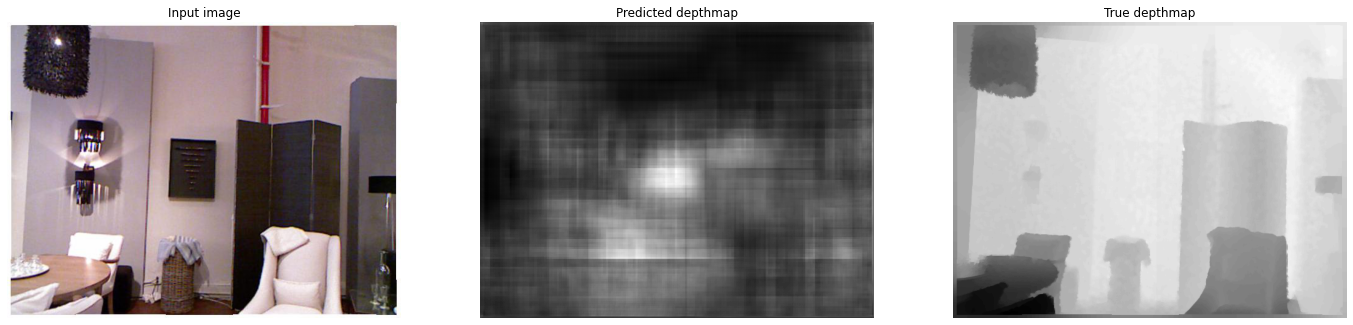

Loss value: 0.21985289454460144


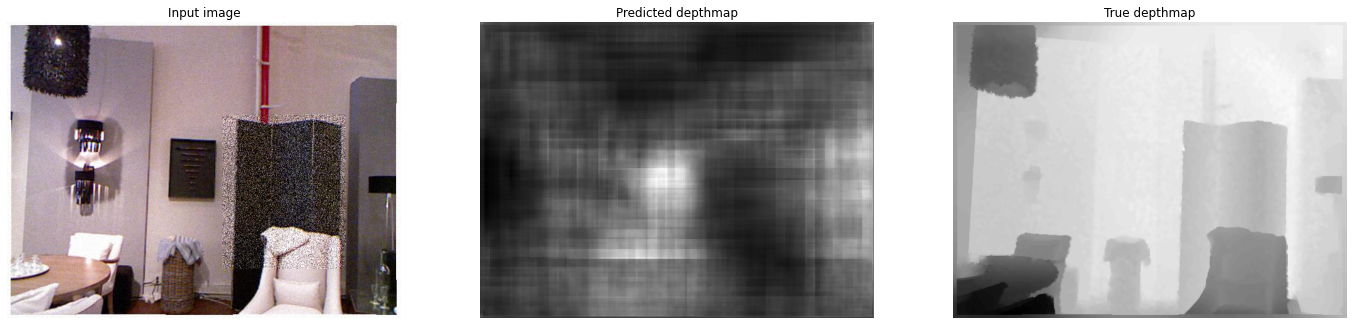

In [ ]:
testset_att.set_tx(transforms.Compose([
    transforms.ToTensor(),
    targetted_object_noise_sample24(0.2)
]))

print('Showing original and attacked samples\n')

x, y = testset[24]
x_att, y_att = testset_att[24]
display_predictions(trained_model, x, y, criterion)  
display_predictions(trained_model, x_att, y_att, criterion)  

### Sample 2 (Testset sample 30)

Showing input, prediction and truth for original and attacked samples

Loss value: 0.2300182431936264


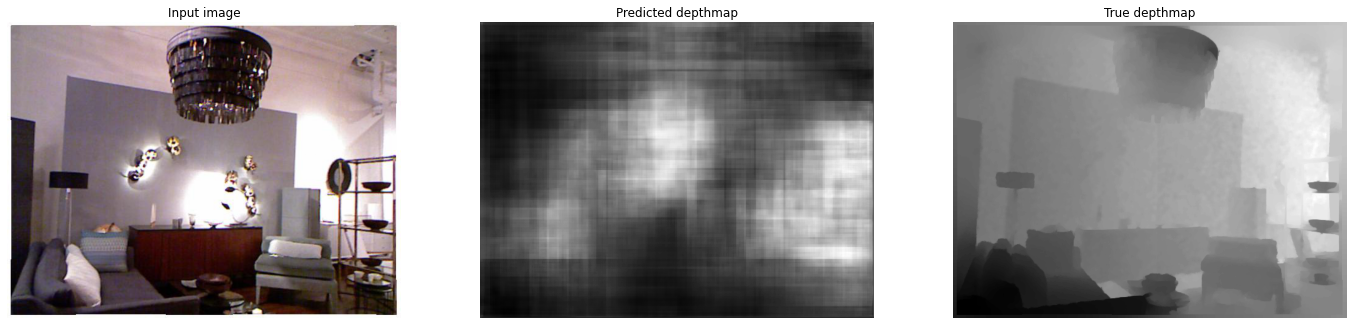

Loss value: 0.26346319913864136


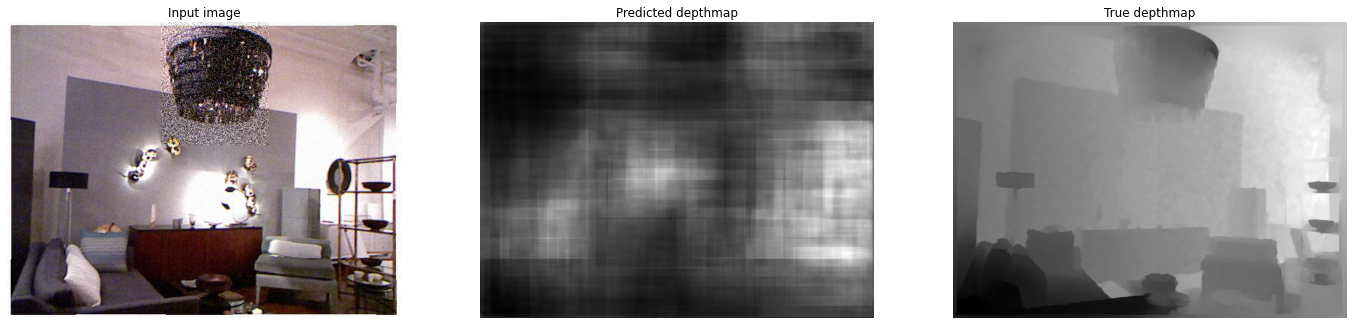

In [ ]:
testset_att.set_tx(transforms.Compose([
    transforms.ToTensor(),
    targetted_object_noise_sample30(0.2)
]))

print('Showing input, prediction and truth for original and attacked samples\n')

x, y = testset[30]
x_att, y_att = testset_att[30]
display_predictions(trained_model, x, y, criterion)  
display_predictions(trained_model, x_att, y_att, criterion)   

As seen from the examples above, occluding the cabinet in sample 24 and the display shelf in sample 30 results in alteration of our predicted depth. As we increase the 𝜖 of our perturbation, the predicted depth of this object will become darker which indicates that it is nearer. Additionally, it also affects the predicted depth of other objects as the model starts to focus on these objects instead.

## Fast Gradient Sign Method (FGSM)

In [9]:
# Note:
# For this cell, if you have ran other attack cells,
# re-run the cell. Otherwise, this cell will display 
# attack results of the previous attack that you ran.

testset_att.set_tx(transforms.Compose([
    transforms.ToTensor(),
    transform_fgsm_attack(trained_model, testloader_att, criterion, 0.25)
]))
@interact(index=(0, 15))
def see(index):
    print('Showing original and attacked samples\n')
    # display original results
    x, y = testset[index]
    display_predictions(trained_model, x, y, criterion)  

    # display attack results
    x_att, y_att = testset_att[index]
    display_predictions(trained_model, x_att, y_att, criterion)  

interactive(children=(IntSlider(value=7, description='index', max=15), Output()), _dom_classes=('widget-intera…

As seen from above, our generated attack samples result in an increase in loss value as 𝜖 increases. Our predicted depth map also become increasingly less interpretable as the depth map starts to predict all the objects to be of almost the same depth. When we increase 𝜖 by just 0.05, we can observe a big difference in the predicted depth map, whereby the brighter parts immediately turn darker, indicating that it predicts the further object to be much nearer now. Our generated attack sample is also plausible with 𝜖 value less than 0.3. Any higher 𝜖 value makes the image too distorted and difficult for us to even tell the depth.

# Interpretability: Shadow based-analysis

In [ ]:
#---------- preparing the data ----------#
# file dirs
i_data_filename = 'data/interpretability_samples.zip'
i_sample_filenames = 'sample_filenames.csv'

# extract filenames from zip file
i_zf = ZipFile(i_data_filename)
i_data = i_zf.read(i_sample_filenames).decode("utf-8") 
i_data = [line.split(',') for line in i_data.split()]

i_dataset = depth_est_dataset_v2(i_data, i_zf)

#--------- get trained model ----------#
trained_model = depth8sig(8)
trained_model.load_model('models/Depth8.pt') # change this to new model to find out how the new model does
criterion = depthEstLossLog()

@interact(index=(0, len(i_dataset)//2-1))
def see(index):
    x, y = i_dataset[2*index]
    x_edited, y = i_dataset[2*index+1]
    print("Original input image")
    display_predictions(trained_model, x, y, criterion)

    print("Edited input image")
    display_predictions(trained_model, x_edited, y, criterion)

interactive(children=(IntSlider(value=2, description='index', max=4), Output()), _dom_classes=('widget-interac…

Our hypothesis was that shadows help the model to interpret depth. To do so, we compared 5 sets of images, one unedited, and one edited (on photoshop) such that the shadows are replaced by colours from the surrounding. By comparing the unedited images with the edited shadow images, we can see the loss being less for 3 out of 5 of the edited images. This could mean that the shadows do not make much of a difference in our model detecting depth.